<a href="https://colab.research.google.com/github/Combi2k2/Combi-Unet/blob/master/Combi_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"combi2k2","key":"a7571c9c172a0c5f9460a4129337f6c3"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d bulentsiyah/semantic-drone-dataset

100% 3.88G/3.89G [00:24<00:00, 213MB/s]
100% 3.89G/3.89G [00:24<00:00, 171MB/s]


In [ ]:
! unzip semantic-drone-dataset.zip

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
import cv2
from PIL import Image

In [ ]:
if (torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print(device)

cuda Tesla T4


## Structrue of Unet's components:

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

In [ ]:
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1)

    def forward(self, x):
        return self.conv(x)

## Structure of Unet (By combining its components)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        
        return  self.outc(x)

## Preparing Dataset

In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torch.utils.data import random_split

In [ ]:
import os
import sys

In [ ]:
df = pd.read_csv('/content/class_dict_seg.csv')
RGB_to_class = np.zeros((256, 256, 256))

print(df)

           name    r    g    b
0     unlabeled    0    0    0
1    paved-area  128   64  128
2          dirt  130   76    0
3         grass    0  102    0
4        gravel  112  103   87
5         water   28   42  168
6         rocks   48   41   30
7          pool    0   50   89
8    vegetation  107  142   35
9          roof   70   70   70
10         wall  102  102  156
11       window  254  228   12
12         door  254  148   12
13        fence  190  153  153
14   fence-pole  153  153  153
15       person  255   22   96
16          dog  102   51    0
17          car    9  143  150
18      bicycle  119   11   32
19         tree   51   51    0
20    bald-tree  190  250  190
21    ar-marker  112  150  146
22     obstacle    2  135  115
23  conflicting  255    0    0


In [ ]:
mask = cv2.imread('/content/dataset/semantic_drone_dataset/label_images_semantic/000.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, dsize = (600, 400), interpolation = cv2.INTER_AREA)

print(mask.shape)
print(mask.max())

(400, 600)
22


In [ ]:
class BasicDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir):
        self.images = []
        self.masks  = []

        show_size = True

        for file in os.listdir(imgs_dir):
            img  = cv2.imread(imgs_dir  + '/' + file[:-4] + '.jpg')
            mask = cv2.imread(masks_dir + '/' + file[:-4] + '.png', cv2.IMREAD_GRAYSCALE)

            if (not np.any(mask)):
                continue
            
            img  = cv2.resize(img,  dsize = (600, 400), interpolation = cv2.INTER_AREA)
            mask = cv2.resize(mask, dsize = (600, 400), interpolation = cv2.INTER_AREA)

            self.images.append(img)
            self.masks.append(mask)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):
        img  = self.images[i].transpose((2, 0, 1))
        mask = self.masks[i]

        img  = torch.from_numpy(img).type(torch.FloatTensor)
        mask = torch.from_numpy(mask).type(torch.FloatTensor)

        return img, mask

In [ ]:
num_epochs = 100
batch_size = 8
learning_rate = 0.005
val_portion = 0.1

In [ ]:
dataset = BasicDataset(imgs_dir  = '/content/dataset/semantic_drone_dataset/original_images',
                        masks_dir = '/content/dataset/semantic_drone_dataset/label_images_semantic')

In [ ]:
n_valid = int(len(dataset) * val_portion)
n_train = len(dataset) - n_valid

train_ds, valid_ds = random_split(dataset, [n_train, n_valid])

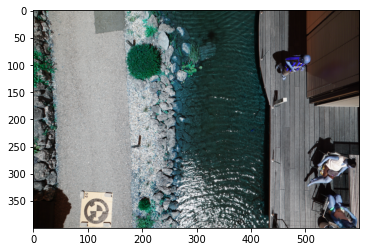

In [ ]:
img, mask = train_ds[0]

img = img.type(torch.int).data.numpy()
img = img.transpose((1, 2, 0))

mask = mask.type(torch.int).data.numpy()

plt.imshow(img)

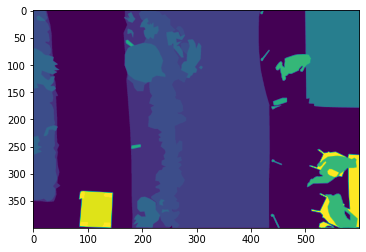

In [ ]:
plt.imshow(mask)

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

## Initialize The model

In [ ]:
My_Unet = UNet(n_channels = 3,
               n_classes = 24).to(device)

In [ ]:
optimizer = torch.optim.SGD(My_Unet.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def eval_net(net, loader, device):
    loss = 0
    n_batch = 0

    for images, masks in loader:
        images = images.to(device, dtype = torch.float32)
        masks  =  masks.to(device, dtype = torch.long)

        with torch.no_grad():
            pred_mask = net(images)
            loss += criterion(pred_mask, masks).item()
        
        n_batch += 1

    return  loss / n_batch

In [ ]:
print(eval_net(My_Unet, valid_dl, device))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


3.204265753428141


In [ ]:
#My_Unet.load_state_dict(torch.load('Combi_Unet.model', map_location = torch.device(device)))

## Start the training Loop:

In [ ]:
epochs = []
train_loss = []
valid_loss = []

In [ ]:
for epoch in range(num_epochs):
    for images, masks in train_dl:
        images = images.to(device, dtype = torch.float32)
        masks  = masks.to(device, dtype = torch.long)

        assert images.shape[1] == My_Unet.n_channels, \
            f'Network has been defined with {My_Unet.n_channels} input channels, ' \
            f'but loaded images have {images.shape[1]} channels. Please check that ' \
            'the images are loaded correctly.'

        # doing forward step and calculate loss
        pred_masks = My_Unet(images)
        loss = criterion(pred_masks, masks)

        # doing backward step
        optimizer.zero_grad();  loss.backward()
        optimizer.step()
    
    #the progress of the model
    epochs.append(len(epochs))
    train_loss.append(eval_net(My_Unet, train_dl, device))
    valid_loss.append(eval_net(My_Unet, valid_dl, device))

    # showing the progress of the model
    if (epoch % 10 == 9):
        print(f'Epoch {epoch + 1}: For each batch, Train_loss = {train_loss[-1]}, Valid_Loss = {valid_loss[-1]}')

        better_cases = 0
        worse_cases = 0

        for i in range(10):
            if (valid_loss[-1] > valid_loss[-i - 1]):   worse_cases += 1
            if (valid_loss[-1] < valid_loss[-i - 1]):   better_cases += 1   

        if (worse_cases > better_cases):
            print("Stopped because of overfitting")
            break

Epoch 10: For each batch, Train_loss = 1.1520437399546306, Valid_Loss = 1.2662163257598877
Epoch 20: For each batch, Train_loss = 0.969982205496894, Valid_Loss = 1.0356114864349366
Epoch 30: For each batch, Train_loss = 0.8066707650820414, Valid_Loss = 0.9508676648139953
Stopped because of overfitting


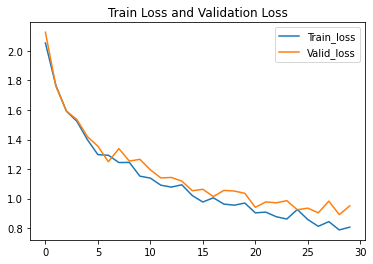

In [ ]:
plt.plot(epochs, train_loss, label = 'Train_loss')
plt.plot(epochs, valid_loss, label = 'Valid_loss')

plt.legend(loc = 'upper right')

plt.title("Train Loss and Validation Loss")
plt.show()

In [ ]:
torch.save(My_Unet.state_dict(), 'Combi_Unet.model')

## Tesing trained model

In [ ]:
def predict(image):
    img = cv2.resize(image, dsize = (600, 400), interpolation = cv2.INTER_AREA)
    img = img.transpose((2, 0, 1))

    img_Tensor = torch.from_numpy(img).type(torch.FloatTensor)
    img_Tensor = img_Tensor.unsqueeze(0)
    img_Tensor = img_Tensor.to(device, dtype = torch.float32)

    with torch.no_grad():
        pred_mask = My_Unet(img_Tensor)[0].cpu().data.numpy()
        pred_mask = pred_mask.argmax(axis = 0)

    return  pred_mask

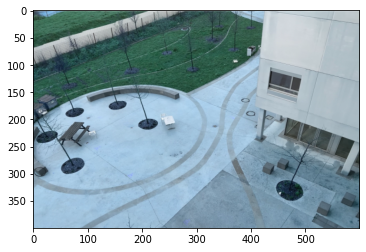

In [ ]:
img = cv2.imread('/content/IMG_0547.jpg')
img = cv2.resize(img, dsize = (600, 400), interpolation = cv2.INTER_AREA)

plt.imshow(img)

In [ ]:
print(img.shape)

(400, 600, 3)


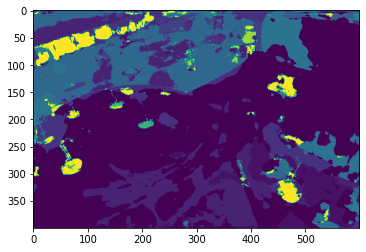

In [ ]:
mask = predict(img)
plt.imshow(mask)

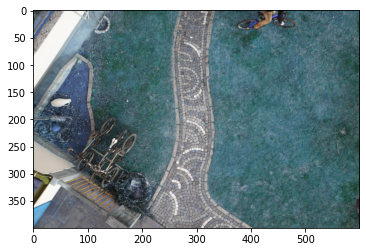

In [ ]:
img, mask = valid_ds[4]

img = img.type(torch.int).data.numpy()
img = img.transpose((1, 2, 0))

mask = mask.type(torch.int).data.numpy()

plt.imshow(img)

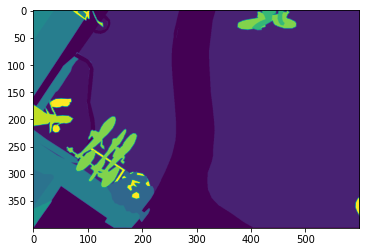

In [ ]:
plt.imshow(mask)

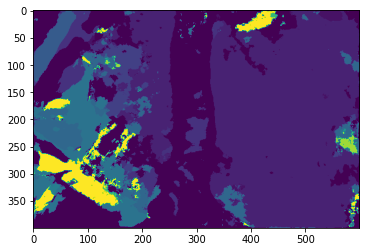

In [ ]:
plt.imshow(predict(img))